In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
match_df_clean = pd.read_csv('match_clean.csv')
team_df = pd.read_csv('team.csv', index_col='team_api_id')
transfers_in = pd.read_csv('transfers_in_clean.csv', index_col=0)
transfers_out = pd.read_csv('transfers_out_clean.csv', index_col=0)

In [118]:
#returns dataframe of end of season table for given year, league
def get_league_table(season, league_name):
    season_df = match_df_clean[(match_df_clean['league_name']==league_name) & (match_df_clean['season']==season)]
    
    league_table_df = pd.DataFrame(0, columns=['Wins', 'Draws', 'Losses', 'Goals_For', 'Goals_Against', 'Goal_Difference', 'Points'],
                                   index=season_df['home_team_name'].unique()).rename_axis('Team')
        
    for i, row in season_df.iterrows():
        league_table_df.loc[row['home_team_name'], 'Goals_For'] += row['home_team_goal']
        league_table_df.loc[row['home_team_name'], 'Goals_Against'] += row['away_team_goal']
        league_table_df.loc[row['away_team_name'], 'Goals_For'] += row['away_team_goal']
        league_table_df.loc[row['away_team_name'], 'Goals_Against'] += row['home_team_goal']
        
        if row['home_win'] == True:
            league_table_df.loc[row['home_team_name'], 'Wins'] += 1
            league_table_df.loc[row['away_team_name'], 'Losses'] += 1
        elif row['away_win'] == True:
            league_table_df.loc[row['home_team_name'], 'Losses'] += 1
            league_table_df.loc[row['away_team_name'], 'Wins'] += 1
        else:
            league_table_df.loc[row['home_team_name'], 'Draws'] += 1
            league_table_df.loc[row['away_team_name'], 'Draws'] += 1
        
    league_table_df['Goal_Difference'] = league_table_df['Goals_For'] - league_table_df['Goals_Against']
    league_table_df['Points'] = league_table_df['Wins']*3 + league_table_df['Draws']
    league_table_df = league_table_df.sort_values(['Points', 'Goal_Difference'], ascending=False).reset_index()
    league_table_df.index = pd.RangeIndex(start=1, stop=len(league_table_df)+1, step=1)
    
    return league_table_df

#returns league finish of given team at end of given season
def get_league_finish(season, team_id):
    league = match_df_clean.league_name[match_df_clean.home_team_api_id==team_id].tolist()[0]
    league_table = get_league_table(season, league)
    team_name = team_df.loc[team_id, 'team_long_name']
    finish = league_table[league_table['Team'] == team_name].index.values.astype(int)[0]
    return finish

In [119]:
transfers_in.head()

,club_name,club_api_id,player_name,age,age_range,position,club_involved_name,fee,transfer_movement,fee_cleaned_millions,league_name,year,season
0,PSV Eindhoven,8640,Danny Koevermans,28.0,23-29,Forward,AZ Alkmaar,£6.21m,in,6.21,Eredivisie,2007,2007/2008
1,PSV Eindhoven,8640,Danko Lazovic,24.0,23-29,Forward,Vitesse,£5.40m,in,5.40,Eredivisie,2007,2007/2008
2,PSV Eindhoven,8640,Balázs Dzsudzsák,21.0,15-22,Forward,Debrecen,£2.25m,in,2.25,Eredivisie,2007,2007/2008
3,PSV Eindhoven,8640,Cássio,20.0,15-22,Defender,Grêmio,£900k,in,0.90,Eredivisie,2007,2007/2008
4,PSV Eindhoven,8640,Kenneth Pérez,32.0,30+,Forward,Ajax,£900k,in,0.90,Eredivisie,2007,2007/2008


In [120]:
transfers_in_by_year = transfers_in.groupby(['club_api_id','club_name','year','league_name',
                                             'age_range','position']).agg({'age':'mean',
                                                                           'fee_cleaned_millions':'sum',
                                                                           'transfer_movement':'count'})
transfers_in_by_year.rename(columns={'age':'average_age', 
                                     'fee_cleaned_millions':'total_spent', 
                                     'transfer_movement':'nTransfers'}, inplace=True)
transfers_in_by_year.reset_index(level=['year','league_name','age_range','position'], inplace=True)

transfers_out_by_year = transfers_out.groupby(['club_api_id','club_name','year','league_name',
                                               'age_range','position']).agg({'age':'mean',
                                                                             'fee_cleaned_millions':'sum',
                                                                             'transfer_movement':'count'})
transfers_out_by_year.rename(columns={'age':'average_age', 
                                     'fee_cleaned_millions':'total_player_revenue', 
                                     'transfer_movement':'nTransfers'}, inplace=True)
transfers_out_by_year.reset_index(level=['year','league_name','age_range','position'], inplace=True)

In [121]:
#get list of teams that spent all 10 years between 2007-2016 in top division of respective league
years_in_top_division = transfers_in_by_year.groupby(['club_api_id','club_name'])['year'].nunique()
top_division_clubs = years_in_top_division[years_in_top_division == 10].index.tolist()
top_division_clubs = [top_division_clubs[i][0] for i in range(len(top_division_clubs))]

In [122]:
#subset transfers by top_division_clubs
transfers_in_by_year = transfers_in_by_year.loc[top_division_clubs]
transfers_out_by_year = transfers_out_by_year.loc[top_division_clubs]

In European soccer, teams that are in the top division have much more money to spend on players due to television deals, greater ticket sales, and in general, wealthier owners who invest more of their own money back into the team. Teams that are able to stay in the top division in the team's respective country will have a consistently higher budget than those who are relegated to lower divisions, even for a short time. For this reason, I will focus on teams that were in the respective country's top division for all 10 years between 2007 and 2016.

In [123]:
yearly_total_in = transfers_in_by_year.groupby('year').agg({'average_age':'mean','total_spent':'sum','nTransfers':'sum'})
yearly_total_out = transfers_out_by_year.groupby('year').agg({'average_age':'mean','total_player_revenue':'sum','nTransfers':'sum'})

In [124]:
yearly_total_in['avg_player_cost'] = yearly_total_in['total_spent']/yearly_total_in['nTransfers']
yearly_total_in['cost_pct_change'] = yearly_total_in['avg_player_cost'].pct_change().fillna(0) * 100
yearly_total_out['rev_per_sale'] = yearly_total_out['total_player_revenue']/yearly_total_out['nTransfers']
yearly_total_out['rps_pct_change'] = yearly_total_out['rev_per_sale'].pct_change().fillna(0) * 100

In [125]:
yearly_total_in

,average_age,total_spent,nTransfers,avg_player_cost,cost_pct_change
year,,,,,
2007,24.173646,1667.195259,1242,1.342347,0.000000
2008,24.106859,1512.826583,1252,1.208328,-9.983951
2009,24.409012,1576.598592,1288,1.224067,1.302568
2010,24.009595,1384.714714,1344,1.030294,-15.830302
2011,24.361604,1587.536519,1431,1.109390,7.677026
2012,24.343419,1396.191974,1289,1.083159,-2.364416
2013,24.248270,1859.666353,1335,1.393009,28.606094
2014,24.192661,1924.797312,1395,1.379783,-0.949419
2015,23.991852,2279.822015,1465,1.556193,12.785306


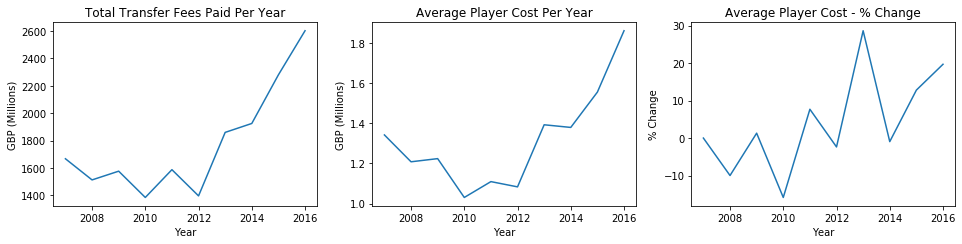

In [126]:
plt.figure(figsize=(13.5,3.5))

plt.subplot(1,3,1)
plt.plot(yearly_total_in['total_spent'])
plt.title('Total Transfer Fees Paid Per Year')
plt.xlabel('Year')
plt.ylabel('GBP (Millions)')

plt.subplot(1,3,2)
plt.plot(yearly_total_in['avg_player_cost'])
plt.title('Average Player Cost Per Year')
plt.xlabel('Year')
plt.ylabel('GBP (Millions)')

plt.subplot(1,3,3)
plt.plot(yearly_total_in['cost_pct_change'])
plt.title('Average Player Cost - % Change')
plt.xlabel('Year')
plt.ylabel('% Change')

plt.tight_layout()

Teams in 2013 started spending significantly more than in previous years, as shown by the near 30% increase in average player cost. There were also sharp increases in total money spent from 2013-2016, despite the slight decrease in average player cost in 2014, though the average player cost in 2014 was still higher than the previous high for the period in 2007.

In [127]:
yearly_total_out

,average_age,total_player_revenue,nTransfers,rev_per_sale,rps_pct_change
year,,,,,
2007,25.313178,1168.137653,1205,0.969409,0.000000
2008,25.324098,1114.976692,1229,0.907223,-6.414852
2009,25.508130,1212.215183,1309,0.926062,2.076593
2010,25.565086,1205.901064,1341,0.899255,-2.894724
2011,25.707329,1245.967132,1424,0.874977,-2.699808
2012,25.557192,1281.681011,1335,0.960061,9.724115
2013,25.400329,1688.934440,1338,1.262283,31.479485
2014,25.285442,1553.391413,1407,1.104045,-12.535841
2015,25.279576,2136.147003,1455,1.468142,32.978473


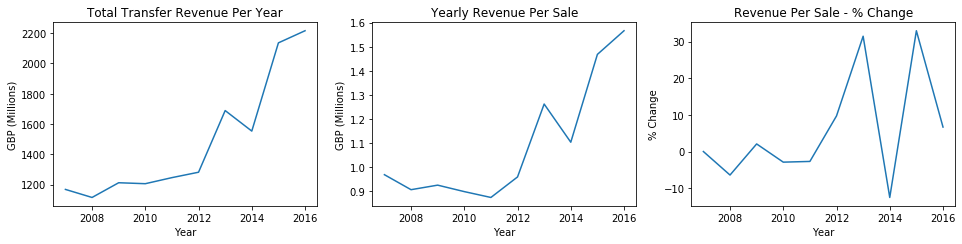

In [128]:
plt.figure(figsize=(13.5,3.5))

plt.subplot(1,3,1)
plt.plot(yearly_total_out['total_player_revenue'])
plt.title('Total Transfer Revenue Per Year')
plt.xlabel('Year')
plt.ylabel('GBP (Millions)')

plt.subplot(1,3,2)
plt.plot(yearly_total_out['rev_per_sale'])
plt.title('Yearly Revenue Per Sale')
plt.xlabel('Year')
plt.ylabel('GBP (Millions)')

plt.subplot(1,3,3)
plt.plot(yearly_total_out['rps_pct_change'])
plt.title('Revenue Per Sale - % Change')
plt.xlabel('Year')
plt.ylabel('% Change')

plt.tight_layout()

Perhaps one reason top teams are spending much more on players is that they have been able to generate more money by selling their own players. The revenue for top teams follows a similar trend to the money they are spending, with the sharp increases in 2013 and 2015, in addition to another slight increase in 2016.

In [72]:
'''spending_by_year_finish = transfers_in_by_year.reset_index().groupby(['club_api_id','club_name','year','league_name']).sum().drop(columns=['average_age']).sort_values('total_spent', ascending=False)
spending_by_year_finish.sort_values(['club_name','year'], inplace=True)
spending_by_year_finish.reset_index(inplace=True)
spending_by_year_finish = spending_by_year_finish[(spending_by_year_finish.year != 2007) & (spending_by_year_finish.year != 2016)]
for i, row in spending_by_year_finish.iterrows():
    spending_by_year_finish.loc[i, 'league_position'] = get_league_finish(row['year'], row['club_api_id'])
    spending_by_year_finish.loc[i, 'position_value'] = len(get_league_table(row['year'], row['league_name'])) - spending_by_year_finish.loc[i, 'league_position']
spending_by_year_finish'''

,club_api_id,club_name,year,league_name,total_spent,nTransfers,league_position,position_value
1,8564,AC Milan,2008,Serie A,61.480000,34,2.0,18.0
2,8564,AC Milan,2009,Serie A,19.890000,25,3.0,17.0
3,8564,AC Milan,2010,Serie A,42.672659,43,1.0,19.0
4,8564,AC Milan,2011,Serie A,53.337301,48,2.0,18.0
5,8564,AC Milan,2012,Serie A,51.307659,45,3.0,17.0
...,...,...,...,...,...,...,...,...
594,10238,Vitória Setúbal FC,2011,Liga Nos,0.000000,24,11.0,5.0
595,10238,Vitória Setúbal FC,2012,Liga Nos,0.014727,20,12.0,4.0
596,10238,Vitória Setúbal FC,2013,Liga Nos,0.024545,28,7.0,9.0
597,10238,Vitória Setúbal FC,2014,Liga Nos,0.004909,28,15.0,3.0


In [ ]:
#writing to csv for future use, code takes a long time to run
spending_by_year_finish.reset_index(drop=True).to_csv('spending_by_year_finish.csv')

In [129]:
spending_by_year_finish = pd.read_csv('spending_by_year_finish.csv', index_col=0)
position_by_league = spending_by_year_finish.groupby(['league_name','club_api_id','club_name']).agg({'total_spent':'sum','nTransfers':'sum','league_position':'mean','position_value':'mean'})
position_by_league.reset_index(level=[1,2], inplace=True)
unique_league_list = position_by_league.index.unique().tolist()
league_position_dict = {league : pd.DataFrame for league in unique_league_list}
for key in league_position_dict.keys():
    league_position_dict[key] = position_by_league[:][position_by_league.index == key]
    league_position_dict[key].sort_values('total_spent', ascending=False, inplace=True)
    league_position_dict[key].reset_index(inplace=True)
league_position_dict['Premier League']

,league_name,club_api_id,club_name,total_spent,nTransfers,league_position,position_value
0,Premier League,8456,Manchester City,950.837361,199,3.500,16.500
1,Premier League,8455,Chelsea FC,674.867789,242,3.625,16.375
2,Premier League,8650,Liverpool FC,616.088000,191,5.750,14.250
3,Premier League,10260,Manchester United,604.069006,187,2.875,17.125
4,Premier League,8586,Tottenham Hotspur,481.226000,255,5.000,15.000
5,Premier League,9825,Arsenal FC,352.791700,166,3.375,16.625
6,Premier League,8472,Sunderland AFC,268.383306,234,14.500,5.500
7,Premier League,8668,Everton FC,184.854586,134,7.500,12.500


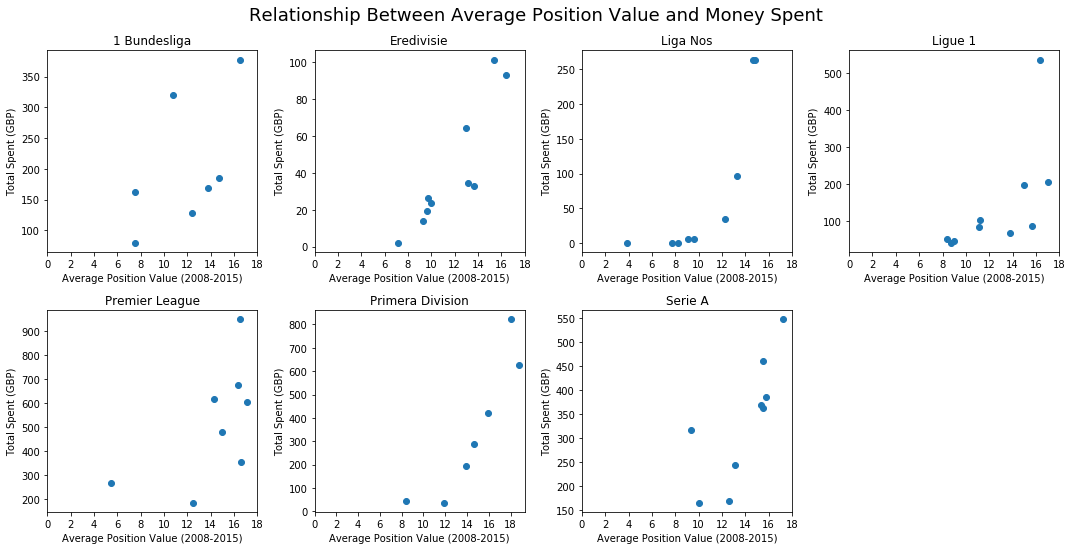

In [130]:
plt.figure(figsize=(15, 8))
plt.suptitle('Relationship Between Average Position Value and Money Spent', fontsize=18)
for i, (k, v) in enumerate(league_position_dict.items()):
    plt.subplot(2, 4, i+1)
    plt.scatter(v.position_value, v.total_spent)
    plt.title(k)
    plt.xticks(np.arange(0,20,step=2))
    plt.xlabel('Average Position Value (2008-2015)')
    plt.ylabel('Total Spent (GBP)')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Certain league's have very different budgets compared to others. For example the top spenders in the Eredivisie (Dutch League), spent around 100 million pounds in the period, while the top spenders in England and Spain are closer to 1 billion pounds. Because of this, I decided to look at each league individually.

I defined position value as the number of other teams a team finished ahead of in their respective league in the given year. For example, a team that finished 1st place in a league of 20 teams would have a position value of 19 for that year. The plots above show a generally positive correlation between money spent and average position value, with some exceptions.

In [131]:
top5_by_league = {}
for k, v in league_position_dict.items():
    v.sort_values('position_value', ascending=False, inplace=True)
    top5_by_league[k] = v.club_name.head().tolist()

In [132]:
unique_league_list = spending_by_year_finish.league_name.unique().tolist()
yearly_spending_dict = {league : pd.DataFrame for league in unique_league_list}
for key in yearly_spending_dict.keys():
    yearly_spending_dict[key] = spending_by_year_finish[(spending_by_year_finish.league_name==key) & (spending_by_year_finish.club_name.isin(top5_by_league[key]))]
    yearly_spending_dict[key].reset_index(drop=True, inplace=True)
yearly_spending_dict['Serie A']

,club_api_id,club_name,year,league_name,total_spent,nTransfers,league_position,position_value
0,8564,AC Milan,2008,Serie A,61.480000,34,2.0,18.0
1,8564,AC Milan,2009,Serie A,19.890000,25,3.0,17.0
2,8564,AC Milan,2010,Serie A,42.672659,43,1.0,19.0
3,8564,AC Milan,2011,Serie A,53.337301,48,2.0,18.0
4,8564,AC Milan,2012,Serie A,51.307659,45,3.0,17.0
5,8564,AC Milan,2013,Serie A,31.980767,49,8.0,12.0
6,8564,AC Milan,2014,Serie A,19.115767,61,10.0,10.0
7,8564,AC Milan,2015,Serie A,83.680972,51,7.0,13.0
8,8686,AS Roma,2008,Serie A,30.430500,44,6.0,14.0
9,8686,AS Roma,2009,Serie A,3.150000,34,2.0,18.0


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


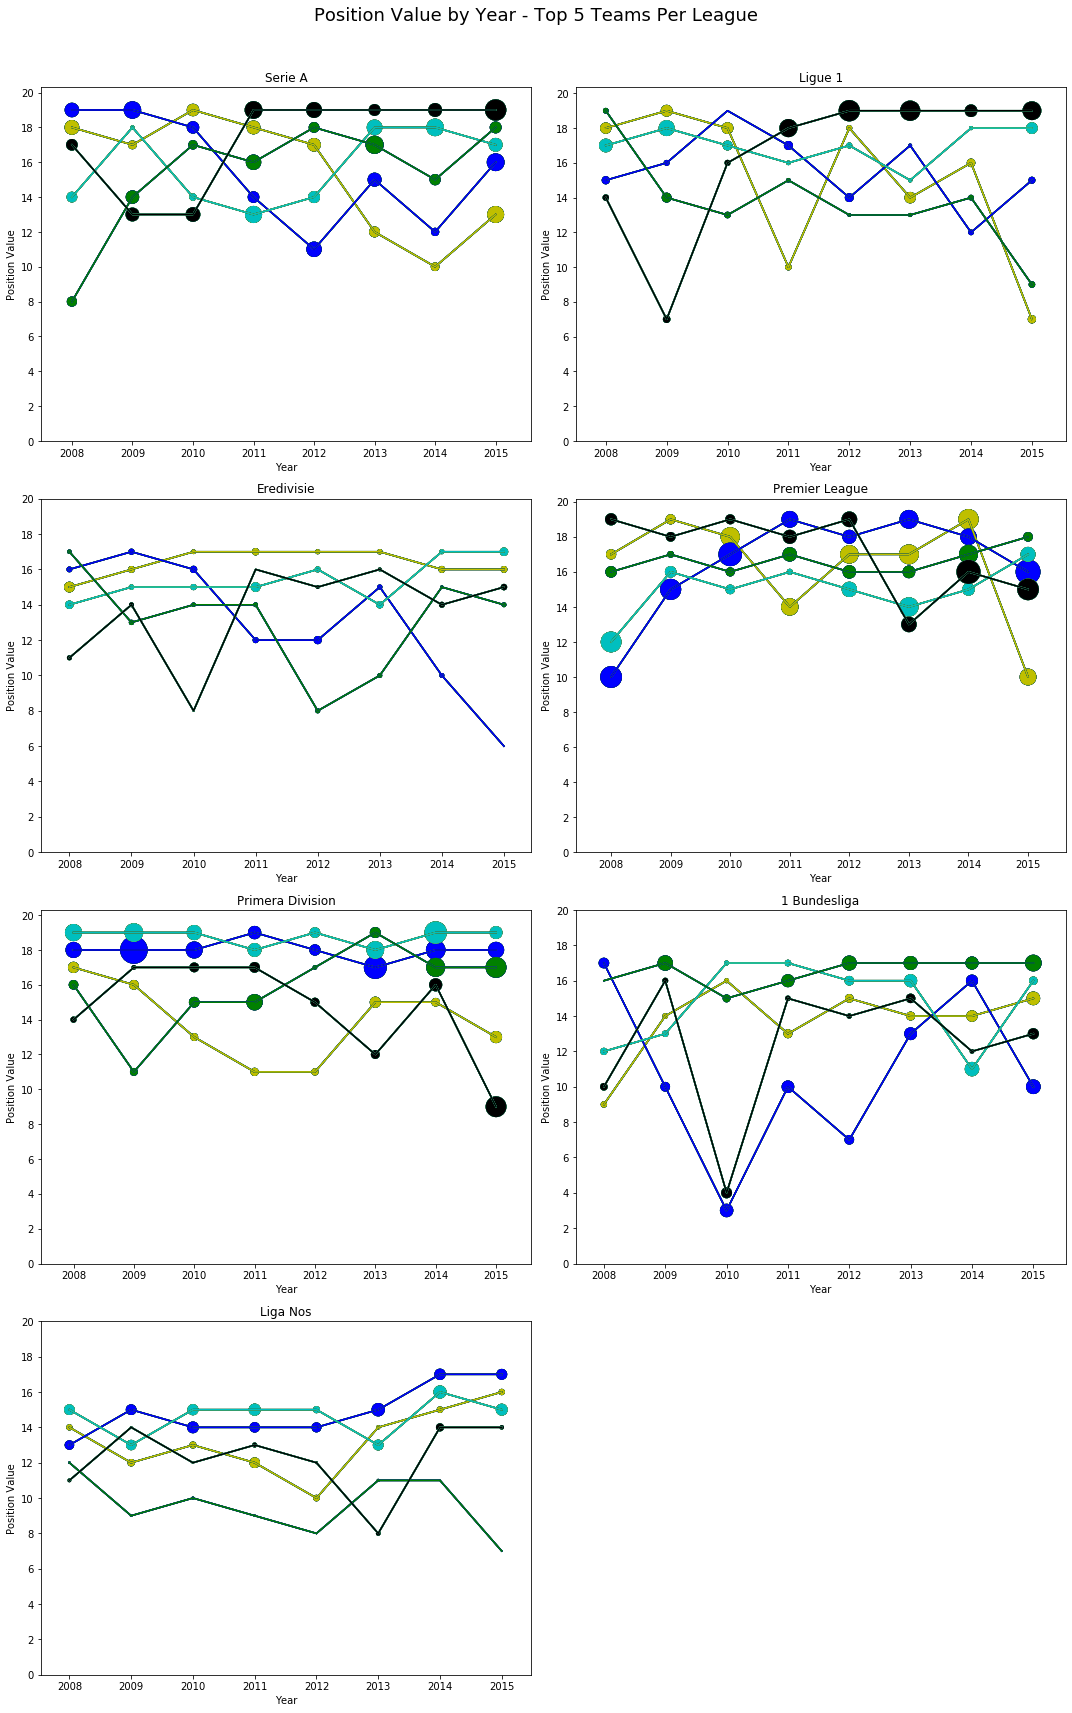

In [133]:
import itertools
plt.figure(figsize=(15, 25))
plt.suptitle('Position Value by Year - Top 5 Teams Per League', fontsize=18)

for i, (k, v) in enumerate(yearly_spending_dict.items()):
    temp_df = v.groupby(['club_api_id', 'club_name', 'year', 'league_name']).sum().reset_index(level=[2,3])
    df_list = []
    for index in temp_df.index.tolist():
        df_list.append(temp_df.loc[index])
    colors = itertools.cycle(['b','g','y','c','k']) 
    for df in df_list:
        plt.subplot(4, 2, i+1)
        color = next(colors)
        plt.scatter(df.year, df.position_value, s=3*df.total_spent, c=color)
        plt.plot(df.year, df.position_value, c=color)
        plt.xticks(np.arange(2008,2016,step=1))
        plt.yticks(np.arange(21, step=2))
        plt.xlabel('Year')
        plt.ylabel('Position Value')
        plt.title(k)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The plots above show the change in position value by year of the teams in each league with the top 5 position values. The dot size in a given year is the team's money spent. In the smaller leagues such as the Eredivisie (Netherlands), Liga Nos (Portugal), and Ligue 1 (France), the teams with higher position values tend to have spent more money, whereas in the league's known to be more competitive, such as the Premier League (England) and Primera Division (Spain), teams that spend the most seem to win less often. 